In [89]:
# install dependencies
!pip install datasets
!pip install -U transformers
!pip install -U datasets

In [90]:
# model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

# transformers for training, tokenization, and model output
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, AutoTokenizer
from transformers import AutoModel
from transformers.modeling_outputs import SequenceClassifierOutput

# neural network components
import torch.nn.functional as F
from torch import nn
import torch

# dataset handling
from datasets import Dataset, ClassLabel
import pandas as pd

# label encoding
from sklearn.preprocessing import LabelEncoder


In [91]:
# load and clean data
csv_path = "/content/final_clean_NBA_dataset.csv"
full_df = pd.read_csv(csv_path)
full_df = full_df[full_df["injury_duration"] != "unknown"]

# encode labels and features
type_encoder = LabelEncoder()
duration_encoder = LabelEncoder()
injury_type_encoder = LabelEncoder()
position_encoder = LabelEncoder()

full_df["label_type_id"] = type_encoder.fit_transform(full_df["injury_type"])
full_df["label_duration_id"] = duration_encoder.fit_transform(full_df["injury_duration"])
full_df["injury_type_id"] = injury_type_encoder.fit_transform(full_df["injury_type"])
full_df["position_id"] = position_encoder.fit_transform(full_df["position"])

# rename cols
full_df = full_df.rename(columns={"notes_clean": "text", "year_end": "year"})

required_cols = [
    "text", "label_type_id", "label_duration_id",
    "prior_injuries", "injury_type_id", "position_id"
]
full_df = full_df[required_cols]

# create huggingface dataset
dataset = Dataset.from_pandas(full_df).shuffle(seed=42).select(range(2000))
dataset = dataset.cast_column("label_type_id",ClassLabel(num_classes=len(type_encoder.classes_), names=list(type_encoder.classes_)))
dataset = dataset.cast_column("label_duration_id",ClassLabel(num_classes=len(duration_encoder.classes_), names=list(duration_encoder.classes_)))


Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [92]:
# load tokenizer for distilbert
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# tokenize and encode inputs with structured features
def tokenize(example):
    # encode text using bert tokenizer
    encoding = tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

    # add numeric features
    encoding["prior_injuries"] = float(example["prior_injuries"])
    encoding["position_id"] = float(example["position_id"])
    encoding["injury_type_id"] = float(example["injury_type_id"])

    # add labels
    encoding["label_type_id"] = example["label_type_id"]
    encoding["label_duration_id"] = example["label_duration_id"]

    return encoding

# apply tokenizer to the dataset
dataset = dataset.map(tokenize)

# set dataset format for pytorch model training
dataset.set_format(type="torch",columns=["position_id","input_ids","attention_mask","prior_injuries","injury_type_id","label_type_id","label_duration_id"])


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [136]:
class DualHeadModelWithAttentionScore(nn.Module):
    def __init__(self, model_name, num_type_labels, num_duration_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)

        self.fc = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size + 4, 256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.classifier_type = nn.Linear(256, num_type_labels)
        self.classifier_duration = nn.Linear(256, num_duration_labels)

    def forward(self, input_ids, attention_mask, prior_injuries, injury_type_id, position_id, attention_score, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_dim]
        def safe_reshape(x):
            return x.view(-1, 1).float()

        prior_injuries = safe_reshape(prior_injuries)
        injury_type_id = safe_reshape(injury_type_id)
        position_id = safe_reshape(position_id)
        attention_score = safe_reshape(attention_score)

        combined = torch.cat([cls_token, prior_injuries, injury_type_id, position_id, attention_score], dim=1)
        x = self.fc(combined)

        logits_type = self.classifier_type(x)
        logits_duration = self.classifier_duration(x)
        return SequenceClassifierOutput(loss=None, logits=(logits_type, logits_duration))


In [137]:
def compute_metrics(pred):
    # unpack predicted logits for both classifications
    logits_type, logits_duration = pred.predictions

    # get predicted class indices
    type_preds = np.argmax(logits_type, axis=1)
    duration_preds = np.argmax(logits_duration, axis=1)

    # convert ground truth labels to numpy array
    labels = np.array(pred.label_ids)

    # transpose
    if labels.ndim == 2 and labels.shape[0] == 2:
        labels = labels.T

    # separate labels for type and duration
    label_type_id = labels[:, 0]
    label_duration_id = labels[:, 1]

    # return accuracy
    return {
        "type_acc": accuracy_score(label_type_id, type_preds),
        "duration_acc": accuracy_score(label_duration_id, duration_preds)
    }


In [138]:
# custom trainer class for dual-head model with structured features
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # extract labels from input dictionary
        labels_type = inputs.pop("label_type_id")
        labels_duration = inputs.pop("label_duration_id")

        # extract structured features
        prior_injuries = inputs.pop("prior_injuries")
        injury_type_id = inputs.pop("injury_type_id")
        position_id = inputs.pop("position_id")

        # forward pass through the model
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            prior_injuries=prior_injuries,
            injury_type_id=injury_type_id,
            position_id=position_id
        )

        # extract logits for each classification head
        logits_type, logits_duration = outputs.logits

        # compute loss for type prediction
        loss_type = F.cross_entropy(logits_type, labels_type)

        # compute loss for duration prediction
        loss_duration = F.cross_entropy(logits_duration, labels_duration)

        # total loss is the sum of both
        loss = loss_type + loss_duration

        # return loss and optionally model outputs
        return (loss, outputs) if return_outputs else loss


In [139]:
# initalize model
model = DualHeadModel(
    model_name="distilbert-base-uncased",
    num_type_labels=len(type_encoder.classes_),
    num_duration_labels=len(duration_encoder.classes_)
)

# train-test split
split = dataset.train_test_split(test_size=0.1)

# trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=split["train"],
    eval_dataset=split["test"],
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

# train the model
trainer.train()

Step,Training Loss
50,2.528700
100,1.804400
150,1.240900
200,1.076100
250,1.035600
300,0.986100
350,0.919800
400,0.934300
450,0.898900


TrainOutput(global_step=452, training_loss=1.2671538934243465, metrics={'train_runtime': 64.0435, 'train_samples_per_second': 112.424, 'train_steps_per_second': 7.058, 'total_flos': 0.0, 'train_loss': 1.2671538934243465, 'epoch': 4.0})

In [140]:
# evaluate trainer
training_args = TrainingArguments(
    output_dir="./injury_classifier",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_strategy="epoch",
    fp16=True,
    label_names=[ "label_type_id", "label_duration_id"]
)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=split["train"],
    eval_dataset=split["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.evaluate()


<ipython-input-140-7a59c6c7b53b>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


{'eval_loss': 0.8743904829025269,
 'eval_model_preparation_time': 0.0018,
 'eval_type_acc': 0.995,
 'eval_duration_acc': 0.65,
 'eval_runtime': 0.287,
 'eval_samples_per_second': 696.81,
 'eval_steps_per_second': 45.293}

In [81]:
# save model
save_path = "/content/final_injury_model.pt"
torch.save(model.state_dict(), save_path)

save_path


'/content/final_injury_model.pt'

In [166]:
importance_scores = global_feature_importance(
    model, tokenizer, split["test"],
    label_map_type=type_encoder.classes_,
    label_map_duration=duration_encoder.classes_
)


ValueError: not enough values to unpack (expected 4, got 2)

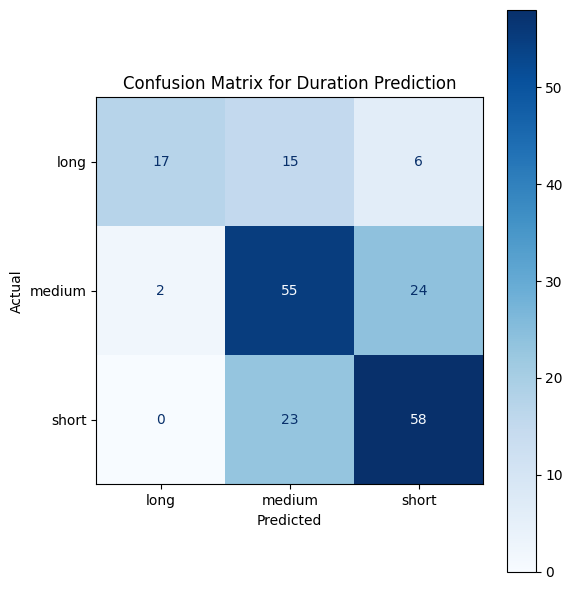

In [87]:
# confusion matrix

# predictions
predictions = trainer.predict(split["test"])
logits_type, logits_duration = predictions.predictions
duration_preds = np.argmax(logits_duration, axis=1)

labels = np.array(predictions.label_ids)

if labels.shape[0] < labels.shape[1] and labels.shape[0] <= 6:
    labels = labels.T  # make shape (N, 6)
assert labels.shape[0] == duration_preds.shape[0], f"Mismatch: labels {labels.shape}, preds {duration_preds.shape}"

true_duration = labels[:, 1]

cm = confusion_matrix(true_duration, duration_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=duration_encoder.classes_)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix for Duration Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [88]:
# classification report

labels = np.array(predictions.label_ids)
if labels.shape[0] < labels.shape[1] and labels.shape[0] <= 6:
    labels = labels.T

true_duration = labels[:, 1]
duration_preds = np.argmax(predictions.predictions[1], axis=1)

print(classification_report(true_duration, duration_preds, target_names=duration_encoder.classes_))


              precision    recall  f1-score   support

        long       0.89      0.45      0.60        38
      medium       0.59      0.68      0.63        81
       short       0.66      0.72      0.69        81

    accuracy                           0.65       200
   macro avg       0.72      0.61      0.64       200
weighted avg       0.68      0.65      0.65       200



In [168]:
import torch.nn.functional as F

def predict_injury(model, tokenizer, text, prior_injuries, injury_type_id, position_id,
                   label_map_type, label_map_duration, attention_score=0.5):
    model.eval()
    device = next(model.parameters()).device

    # tokenize
    encoded = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

    # structure inputs
    prior_injuries = torch.tensor([prior_injuries], dtype=torch.float32).to(device)
    injury_type_id = torch.tensor([injury_type_id], dtype=torch.float32).to(device)
    position_id = torch.tensor([position_id], dtype=torch.float32).to(device)
    attention_score = torch.tensor([attention_score], dtype=torch.float32).to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=encoded["input_ids"],
            attention_mask=encoded["attention_mask"],
            prior_injuries=prior_injuries,
            injury_type_id=injury_type_id,
            position_id=position_id,
            attention_score=attention_score
        )

    logits_type, logits_duration = outputs.logits

    # softmax for confidence
    probs_type = F.softmax(logits_type, dim=1)
    probs_duration = F.softmax(logits_duration, dim=1)

    pred_type_idx = torch.argmax(probs_type, dim=1).item()
    pred_duration_idx = torch.argmax(probs_duration, dim=1).item()

    type_label = label_map_type[pred_type_idx]
    duration_label = label_map_duration[pred_duration_idx]

    type_conf = probs_type[0, pred_type_idx].item()
    duration_conf = probs_duration[0, pred_duration_idx].item()

    return type_label, type_conf, duration_label, duration_conf


In [170]:
texts = [
    "player has a sprained ankle",
    "torn ACL expected to miss rest of season",
    "minor hamstring strain"
]

for t in texts:
    t_type, t_type_conf, t_duration, t_duration_conf = predict_injury(
        model, tokenizer, t,
        prior_injuries=1, injury_type_id=4, position_id=2,
        label_map_type=type_encoder.classes_,
        label_map_duration=duration_encoder.classes_
    )

    print(f"{t}\n  → Type: {t_type} ({t_type_conf:.2%}) | Duration: {t_duration} ({t_duration_conf:.2%})\n")



player has a sprained ankle
  → Type: joint (96.51%) | Duration: medium (54.94%)

torn ACL expected to miss rest of season
  → Type: joint (76.31%) | Duration: long (87.25%)

minor hamstring strain
  → Type: muscle (94.37%) | Duration: medium (52.75%)

